# Binary Classification Features Visualization

In this notebook, we extract feature vectors from images in the public dataset using the trained bit model.

Then, we visualize the features using TSNE plot. 

In [97]:
from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(str(Path.cwd().parent))

import multiprocessing
import os
from loguru import logger
from src.utils.gcs_utils import set_environement_variable

is_env_variables_set = set_environement_variable()
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/home/gauthies/sdd/sdd-general/dist/auth.json'

from src.utils import envs 
e=envs.Envs()

import src.utils.config_manager as config_manager
from src.models.model_factory import model_factory
from src.data.make_dataset import read_images_initial
from src.utils.path_manager import  ModelPathManager
from src.data.GCPDataset import GCPDataset
from src.training.training_hyperparameters import TrainingHyperparameters, set_training_settings, generate_transforms

from src.utils.gcs_utils import load_from_filename
config_manager.download_config_from_gcs()
config=config_manager.init_config()
from src.data.make_dataset import read_images_from_db
from src.utils.utils import logger_config
from src.utils.gcs_utils import image_reader
from src.data.augmentation_factory import augmentationFactory
logger.configure(**logger_config())
load_models = e.load_models
multiprocessing.set_start_method('spawn', force=True)



# 1. Data Loader Creation

In [98]:
size=[224,224]
batch_size= 2
num_workers=4
n_class =2
device = torch.device( "cuda:0" if torch.cuda.is_available() else "cpu")  ## specify the GPU id's, GPU id's start from 0.

In [99]:
df = read_images_initial(config)
df['not_acne'] =  ~df['acne']
image_dataset = GCPDataset(df_dataset=df,  classes=['acne', 'not_acne'],transform= augmentationFactory('noaugment') , mutli_label=False)

dataloaders = torch.utils.data.DataLoader(image_dataset, batch_size=batch_size,shuffle=False, num_workers=num_workers )

# 2. Model Creation

In [100]:
# load model
model_path_manager = ModelPathManager(config)
params = TrainingHyperparameters('bit', config.get('model')['bit'])
set_training_settings(config, params)
model = model_factory(params.model_name, len(params.classes), freeze_layers =params.freeze_layers, 
                           percentage_freeze=params.percentage_freeze, pretrained= True)
model.load_state_dict(torch.load(config.get('predict_model_name')))

bit- Frozen 0/306 layers/blocks in bit.


<All keys matched successfully>

In [101]:
def visualize_tsne(model):
    model = model.to(device)
    model.eval()
    first = True
    y_true = []
    for data in tqdm(dataloaders):
        inputs, labels, _ = data
        y_true.extend(labels.detach().cpu().numpy())
        inputs = Variable(inputs.to(device))
        feature = model.forward_features(inputs)
        feature_size = feature.shape[1] * feature.shape[2] * feature.shape[3]
        feature_np = feature.view(batch_size,feature_size).detach().cpu().numpy()
        if first:
            outputs = feature_np
            first= False
        else:
            outputs = np.concatenate((outputs,feature_np))

    X_embedded = TSNE(n_components=2,init='random').fit_transform(outputs.astype(float))

    item =1
    idx_acne = []
    for index, elem in enumerate(y_true):
        if elem== item:
            idx_acne.append(index)

    item =0
    idx_not_acne = []
    for index, elem in enumerate(y_true):
        if elem== item:
            idx_not_acne.append(index)

    plt.figure(figsize=(15,8))
    plt.scatter(X_embedded[idx_acne,0], X_embedded[idx_acne,1], label='acne')
    plt.scatter(X_embedded[idx_not_acne,0], X_embedded[idx_not_acne,1], label='not_acne')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('TSNE on bit features')
    plt.legend()



# 3. Visualize TSNE Plot

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 316/316 [00:33<00:00,  9.33it/s]


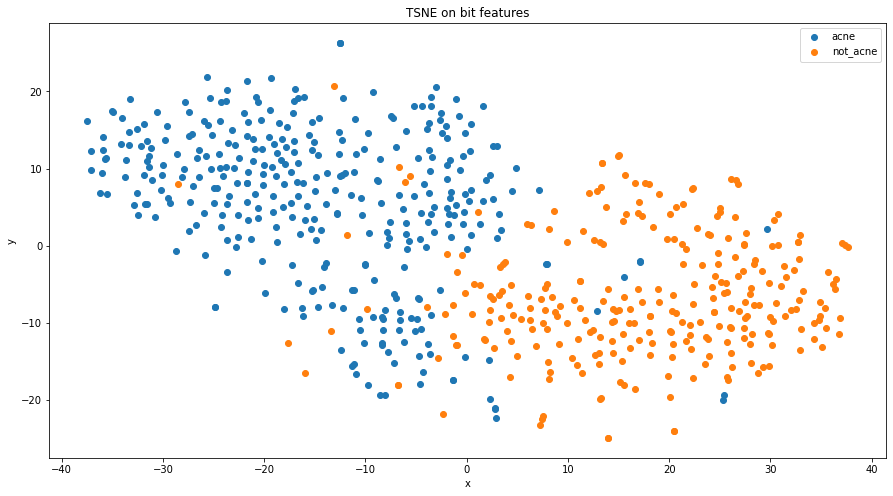

In [102]:
visualize_tsne(model)